# LUng Nodule Analysis

In [1]:
# Import thư viện

import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<b>Đọc CSV file</b>

In [2]:
cand_path = 'CSVFILES/candidates.csv'
annotation_path = 'CSVFILES/annotations.csv'

In [3]:
candidates = pd.read_csv(cand_path)
annotations = pd.read_csv(annotation_path)

In [4]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [5]:
candidates['class'].value_counts()

0    549714
1      1351
Name: class, dtype: int64

In [6]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


<b>Tạo file location của mỗi subset</b>

In [7]:
file_list = [glob.glob('subset0\\*.mhd')][0]
file_list1 = [glob.glob('subset1\\*.mhd')][0]
file_list2 = [glob.glob('subset2\\*.mhd')][0]

In [8]:
file_list[:5]

['subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd']

In [9]:
candidates['file_location'] = ''
candidates['subset'] = ''

In [10]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class,file_location,subset
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0,,
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0,,
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0,,
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0,,
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0,,


In [11]:
def fill_file_location(row):
    seriuid = row.seriesuid
    location = ''
    for loc in file_list:
        
        file = loc.split('\\')[-1]
        file = file.split('.mhd')[0]
        if file == seriuid:
            location = loc.split('\\')[0] + '\\\\' + loc.split('\\')[1]
            row['file_location'] = location
            row['subset'] = 0
            break
    return row
candidates = candidates.apply(fill_file_location, axis=1)

In [12]:
def fill_file_location(row):
    seriuid = row.seriesuid
    location = ''
    for loc in file_list1:
        
        file = loc.split('\\')[-1]
        file = file.split('.mhd')[0]
        if file == seriuid:
            location = loc.split('\\')[0] + '\\\\' + loc.split('\\')[1]
            row['file_location'] = location
            row['subset'] = 1
            break
    return row
candidates = candidates.apply(fill_file_location, axis=1)

In [13]:
def fill_file_location(row):
    seriuid = row.seriesuid
    location = ''
    for loc in file_list2:
        
        file = loc.split('\\')[-1]
        file = file.split('.mhd')[0]
        if file == seriuid:
            location = loc.split('\\')[0] + '\\\\' + loc.split('\\')[1]
            row['file_location'] = location
            row['subset'] = 2
            break
    return row
candidates = candidates.apply(fill_file_location, axis=1)

In [14]:
len(candidates[candidates['file_location'] != ''])

166001

In [15]:
candidates[candidates['file_location'] != ''].head()

,seriesuid,coordX,coordY,coordZ,class,file_location,subset
3038,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-76.62,156.53,-529.43,0,subset2\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100...,2
3039,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,120.13,160.73,-404.68,0,subset2\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100...,2
3040,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,94.23,171.24,-392.76,0,subset2\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100...,2
3041,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,74.62,190.84,-534.34,0,subset2\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100...,2
3042,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-6.60,189.44,-469.16,0,subset2\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100...,2


<b>Hiển thị hình ảnh </b>

In [16]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

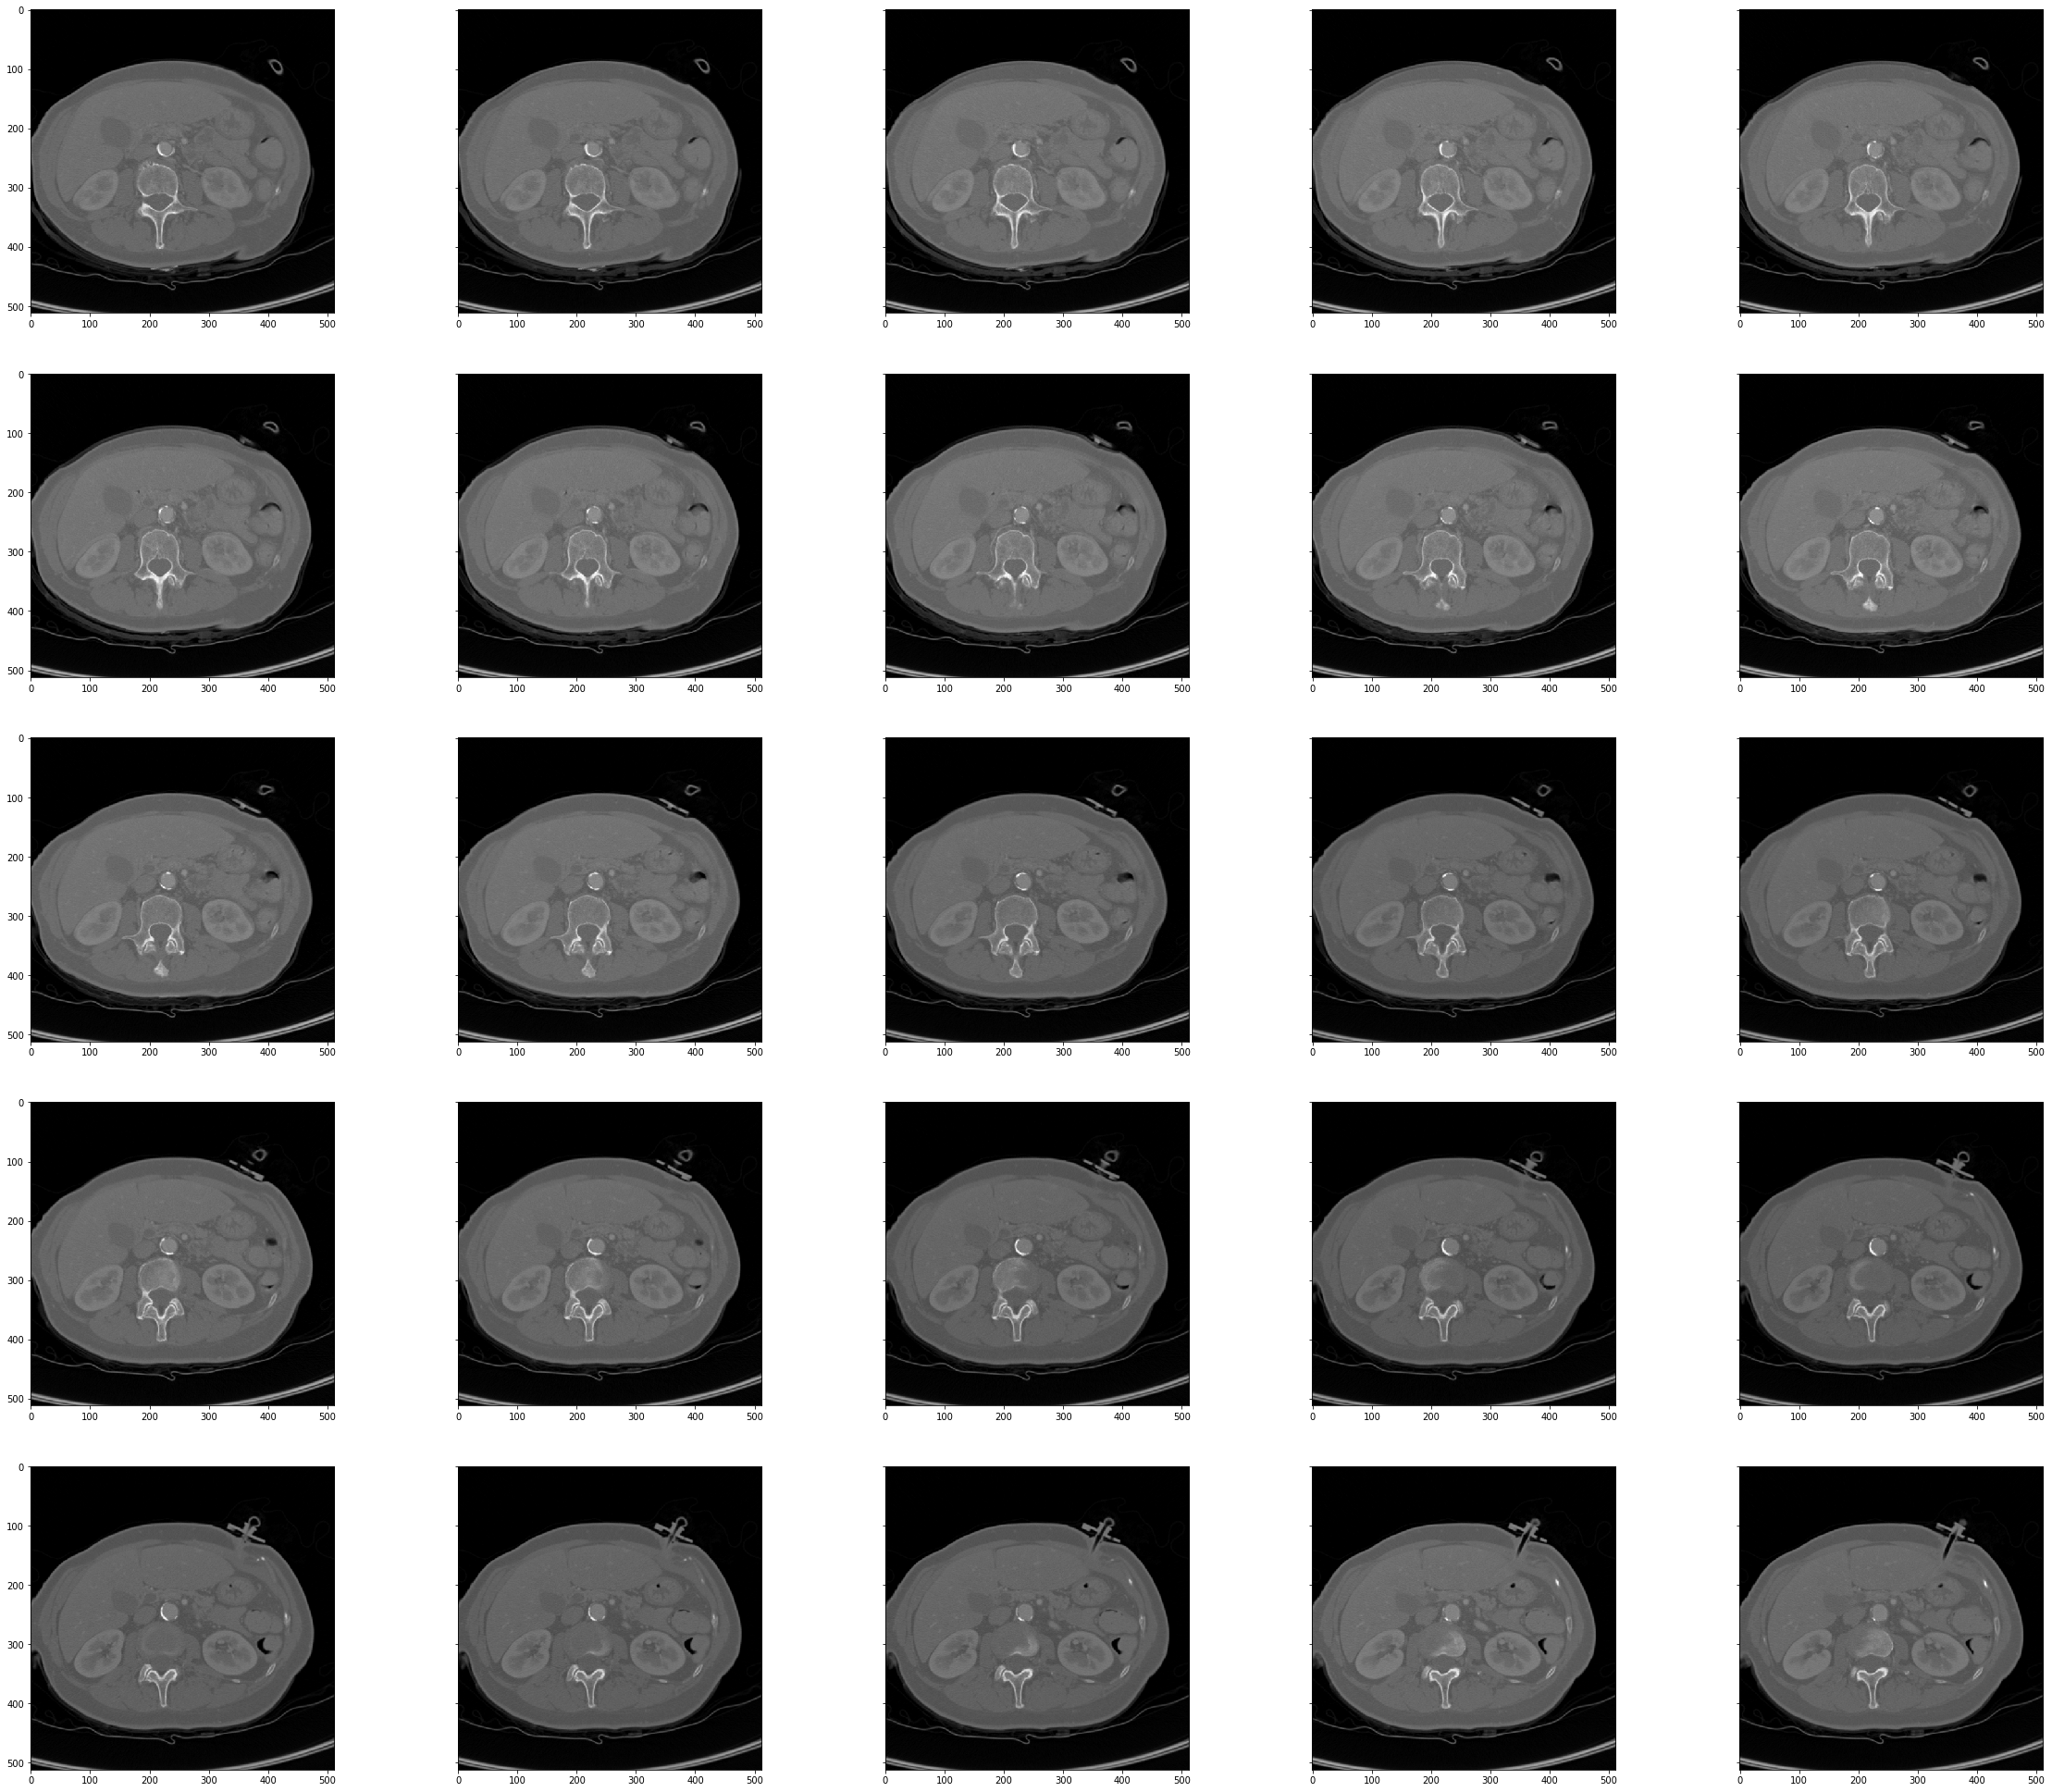

In [17]:
fig, axs = plt.subplots(5,5, figsize=(40, 35), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,25,1)):
    axs[index].imshow(load_itk_image(candidates[candidates['file_location'] != ''].iloc[0]['file_location'])[0][i], cmap=plt.cm.gray)
plt.show()

<b>Chia lớp Positive và Negative</b>

In [18]:
# datapos = candidates[candidates['class']==1][candidates['file_location']!='']
# dataneg = candidates[candidates['class']==0][candidates['file_location']!='']

In [19]:
datapos = candidates[candidates['class']==1][candidates['file_location']!='']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [20]:
dataneg0 = candidates[candidates['class']==0][candidates['file_location']!=''][candidates['subset']==0][:datapos[datapos['subset']==0].shape[0]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [21]:
dataneg1 = candidates[candidates['class']==0][candidates['file_location']!=''][candidates['subset']==1][:datapos[datapos['subset']==1].shape[0]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [22]:
dataneg2 = candidates[candidates['class']==0][candidates['file_location']!=''][candidates['subset']==2][:datapos[datapos['subset']==2].shape[0]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [23]:
dataneg = pd.concat([dataneg0, dataneg1, dataneg2])

In [24]:
dataneg.shape

(433, 7)

<b>Vẽ nodule</b>

In [25]:
def plot_nodule(candidate):
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)
    origin_xyz = np.array(itk_img.GetOrigin())
    spacing_xyz = np.array(itk_img.GetSpacing())
    center_xyz = (candidate['coordX'], candidate['coordY'], candidate['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)

    fig, ax = plt.subplots(1)
    ax.imshow(img_array[nodule_xyz[2]], cmap=plt.cm.gray)
    ax.add_patch(
        patches.Rectangle(
            (nodule_xyz[0] - 16, nodule_xyz[1]-16), 32, 32,
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )

<b>Hình có nodule</b>

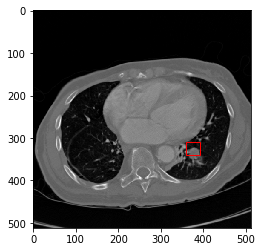

In [26]:
plot_nodule(datapos.iloc[0])

<b>Hình bình thường</b>

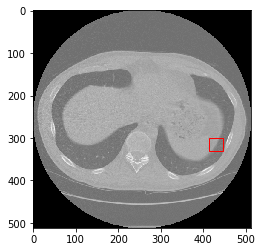

In [27]:
plot_nodule(dataneg.iloc[0])

<b>Lấy dữ liệu từ file .mdh</b>

In [28]:
def getdata(candidate):
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)
    origin_xyz = np.array(itk_img.GetOrigin())
    spacing_xyz = np.array(itk_img.GetSpacing())
    center_xyz = (candidate['coordX'], candidate['coordY'], candidate['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)
    ineed = img_array[nodule_xyz[2], nodule_xyz[1] - 16:nodule_xyz[1]+16, nodule_xyz[0] - 16:nodule_xyz[0]+16]
    ineed = np.array(ineed)
    return ineed

In [29]:
def getdata512(candidate):
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)
    return np.array(img_array)

In [30]:
for j in range(datapos.shape[0]):
    ineed = getdata(datapos.iloc[j])
    path = "data\\1" + "\\" + datapos.iloc[j][0]+str(datapos.iloc[j][1])+str(datapos.iloc[j][1])+str(datapos.iloc[j][2])+str(datapos.iloc[j][3])+".npy"
    np.save(path,ineed)
for j in range(dataneg.shape[0]):
    ineed = getdata(dataneg.iloc[j])
    path = "data\\0" + "\\" + dataneg.iloc[j][0]+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][2])+str(dataneg.iloc[j][3])+".npy"
    np.save(path,ineed)

In [25]:
for j in range(datapos.shape[0]):
    ineed = getdata512(datapos.iloc[j])
    path = "data512\\1" + "\\" + datapos.iloc[j][0]+str(datapos.iloc[j][1])+str(datapos.iloc[j][1])+str(datapos.iloc[j][2])+str(datapos.iloc[j][3])+".npy"
    np.save(path,ineed)
    
for j in range(datapos.shape[0]):
    ineed = getdata512(dataneg.iloc[j])
    path = "data512\\0" + "\\" + dataneg.iloc[j][0]+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][2])+str(dataneg.iloc[j][3])+".npy"
    np.save(path,ineed)

<b>Train và Test</b>

In [31]:
training_img = []
training_label = []
for dir_path in glob.glob("data/*"):
    img_label = dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.npy")):
        image = np.load(image_path)
        training_img.append(image)
        training_label.append(img_label)
training_img = np.array(training_img)
training_label = np.array(training_label)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(training_img, training_label, test_size=0.2, random_state=42)

In [40]:
X_train.shape

(692, 32, 32)

In [41]:
X_test.shape

(174, 32, 32)

In [42]:
# input image dimensions
height, width = X_train.shape[1], X_train.shape[2]
input_shape = (height,width,1)

x_train = X_train.reshape(X_train.shape[0],  height, width, 1)
x_test = X_test.reshape(X_test.shape[0], height, width, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [43]:
# Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, 
# as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 
# competition to normalize between are -1000 and 400. 
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [44]:
x_train = normalize(x_train)

In [45]:
x_test = normalize(x_test)

In [46]:
y_train_one_hot_encode = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot_encode = keras.utils.to_categorical(y_test, num_classes)

In [47]:
batch_size = 64
num_classes = 2
epochs = 30

In [48]:
def model(input_shape = (32, 32, 1)):
    # Initialising the CNN
    classifier = Sequential()
    # Step 1 - Convolution
    classifier.add(Conv2D(32, (3, 3), input_shape = input_shape, padding='same', use_bias=False))

    #Set use_bias=False in layers.conv2d() and layers.dense() because BatchNormalization
    classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))

    classifier.add(Conv2D(32, (3, 3), use_bias=False))
    classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a second convolutional layer
    classifier.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
    classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))

    classifier.add(Conv2D(32, (3, 3), use_bias=False))
    classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))

    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Step 3 - Flattening
    # taking the 2-D array, i.e pooled image pixels and converting them to a one dimensional single vector.
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = 256, kernel_initializer='he_normal', use_bias=False))
    classifier.add(BatchNormalization())
    classifier.add(Activation('relu'))

    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = num_classes, activation = 'softmax', kernel_initializer='he_normal'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [49]:
classifier = model((height, width, 1))

classifier.fit(x_train, y_train1h, batch_size=batch_size,
        epochs=epochs, verbose=1, validation_data=(x_test, y_test1h))

Train on 692 samples, validate on 174 samples
Epoch 1/30
692/692 [==============================] - 15s 21ms/step - loss: 0.6646 - acc: 0.6965 - val_loss: 0.5800 - val_acc: 0.6954
Epoch 2/30
692/692 [==============================] - 13s 19ms/step - loss: 0.3212 - acc: 0.8714 - val_loss: 0.5839 - val_acc: 0.7586
Epoch 3/30
692/692 [==============================] - 14s 20ms/step - loss: 0.2210 - acc: 0.9133 - val_loss: 0.9053 - val_acc: 0.6954
Epoch 4/30
692/692 [==============================] - 14s 21ms/step - loss: 0.1374 - acc: 0.9552 - val_loss: 0.4384 - val_acc: 0.7759
Epoch 5/30
692/692 [==============================] - 14s 20ms/step - loss: 0.0915 - acc: 0.9783 - val_loss: 0.6692 - val_acc: 0.7414
Epoch 6/30
692/692 [==============================] - 14s 20ms/step - loss: 0.0679 - acc: 0.9841 - val_loss: 0.4858 - val_acc: 0.8046
Epoch 7/30
692/692 [==============================] - 14s 20ms/step - loss: 0.0510 - acc: 0.9913 - val_loss: 0.6114 - val_acc: 0.7586
Epoch 8/30
692/6

In [50]:
y_predict = classifier.predict_classes(x_test, batch_size = None)
print(classification_report(y_predict, y_test))

             precision    recall  f1-score   support

          0       0.75      0.85      0.80        79
          1       0.86      0.77      0.81        95

avg / total       0.81      0.80      0.80       174



In [51]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [52]:
model = unet(input_size = (height, width,1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49:

In [53]:
model.fit(x_train, y_train, batch_size=batch_size,
        epochs=epochs, verbose=1,
        validation_data=(x_test, y_test))

ValueError: Error when checking target: expected conv2d_32 to have 4 dimensions, but got array with shape (692, 1)

In [96]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(32, 32, 1),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(2, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [97]:
model = inception()

ValueError: The input must have 3 channels; got `input_shape=(32, 32, 1)`